In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from bibliometric_sec2prim import read_config_file
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Sec2Pri Index for literature using primary and secondary HGNC symbols

This notebook analyzes the data obtained from [`bibliometric_sec2prim.py`](bibliometric_sec2prim.py). 

The sec2pri index is calculated as follows: 

With p = number of instances of a publication containing a primary symbol in its abstract and s = number of publications using a secondary symbol in its abstract:
$$ sec2pri = {s \over s + p} $$

# 1. Importing data

In [2]:
CONFIG = read_config_file('config.yml', 'hgnc')
CONFIG.keys()

dict_keys(['hgnc', 'chebi'])

First we import the HGNC mappings table.

In [3]:
hgncs = pd.read_csv(CONFIG['hgnc']['path'], sep='\t')
hgncs.head()

,primaryID,primarySymbol,secondaryID,secondarySymbol,predicateID,mapping_cardinality_sec2pri,comment,source
0,Entry Withdrawn,Entry Withdrawn,HGNC:1,A12M1,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
1,Entry Withdrawn,Entry Withdrawn,HGNC:2,A12M2,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
2,Entry Withdrawn,Entry Withdrawn,HGNC:3,A12M3,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
3,Entry Withdrawn,Entry Withdrawn,HGNC:4,A12M4,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
4,HGNC:12469,UBA1,HGNC:6,A1S9T,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...


Now we import the data obtained from `bibliometric_sec2prim.py` into a pandas DataFrame:

In [4]:
def generate_adoption_data(df, json_file):
    try:
        # Read the JSON file
        with open(json_file, 'r') as json_data:
            json_content = json.load(json_data)['result']

        # Create a DataFrame for primary and secondary symbols
        symbol_columns = ['primarySymbol', 'secondarySymbol', 'mapping_cardinality_sec2pri']
        primary_df = df[symbol_columns].drop_duplicates()
        secondary_df = df[symbol_columns].drop_duplicates()

        # Initialize a list to store adoption data
        adoption_data = []

        # Process firstColumn_alt and secondColumn_alt data
        for alt_data, symbol_type in [(json_content.get('firstColumn_alt', []), 'primary'),
                                     (json_content.get('secondColumn_alt', []), 'secondary')]:
            for entry in alt_data:
                symbol, article_data = entry.popitem()
                symbol_df = primary_df if symbol_type == 'primary' else secondary_df
                symbol_row = symbol_df[symbol_df[symbol_type + 'Symbol'] == symbol]
                if not symbol_row.empty:
                    symbol_row = symbol_row.iloc[0]
                    for article in article_data.values():
                        primary_symbol = symbol_row['primarySymbol'] if symbol_type == 'secondary' else symbol
                        secondary_symbol = symbol if symbol_type == 'secondary' else symbol_row['secondarySymbol']
                        journal_title = article.get('journalInfo.journal.title', 'NA')
                        pubYear = article.get('pubYear', 'NA')
                        cardinality = symbol_row['mapping_cardinality_sec2pri']
                        pmid = article.get('pmid', 'NA')

                        # Check for 'NA' values and skip the loop iteration if any is found
                        if 'NA' in [primary_symbol, secondary_symbol, journal_title, pubYear, cardinality, pmid]:
                            continue

                        adoption_data.append({
                            'primarySymbol': primary_symbol,
                            'secondarySymbol': secondary_symbol,
                            'journal_title': journal_title,
                            'pubYear': pubYear,
                            'mapping_cardinality_sec2pri': cardinality,
                            'symbol_type': symbol_type,
                            'pmid': pmid
                        })

        # Create a DataFrame from the adoption_data list
        adoption_df = pd.DataFrame(adoption_data)
        adoption_df = adoption_df[adoption_df['pubYear'] != np.nan]
        adoption_df = adoption_df[adoption_df['pubYear'] != 'NA']
        adoption_df['pubYear'] = pd.to_numeric(adoption_df['pubYear'])
        adoption_df['symbol_type'] = adoption_df['symbol_type'].astype('category')
        adoption_df['symbol_code'] = ['0' if i=='primary' else '1' for i in adoption_df['symbol_type']]
        adoption_df['symbol'] = np.where(adoption_df['symbol_type'] == 'primary', adoption_df['primarySymbol'], adoption_df['secondarySymbol'])
        adoption_df = adoption_df[adoption_df['primarySymbol'] != 'Entry Withdrawn']
        return adoption_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of errors


In [5]:
adoption_df = generate_adoption_data(hgncs, 'result/hgnc_with_journal.json')
adoption_df.sample(5)


,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,symbol_code,symbol
151099,PPT1,PPT,Acta neuropathologica communications,2014,1:1,primary,24887158,0,PPT1
463242,CCDC6,TST1,"Genes, chromosomes & cancer",1992,1:1,secondary,1283325,1,TST1
235266,LMX1A,LMX1,"Journal of neural transmission (Vienna, Austri...",2023,1:1,primary,36820885,0,LMX1A
171140,DUSP1,PTPN10,"Advanced science (Weinheim, Baden-Wurttemberg,...",2022,1:1,primary,34816611,0,DUSP1
258789,HIRA,TUPLE1,The Australasian journal of dermatology,2021,1:1,primary,33527370,0,HIRA


In [6]:
adoption_df.describe()

,pubYear
count,454990.000000
mean,2013.366667
std,8.337542
min,1913.000000
25%,2009.000000
50%,2015.000000
75%,2020.000000
max,2024.000000


`adoption_df` allows to plot the evolution of the usage of primary identifiers vs secondary identifiers:

In [7]:
def plot_adoption_evolution(adoption_df, year_range=(2000, 2022)):
    try:

        # Filter by year range
        adoption_df = adoption_df[(adoption_df['pubYear'] >= year_range[0]) & (adoption_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Count the number of primary symbols for each year
        primary_counts = adoption_df[adoption_df['symbol_type'] == 'primary'].groupby('pubYear').size()

        # Count the number of secondary symbols for each year
        secondary_counts = adoption_df[adoption_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

        primary_normalized = primary_counts / (primary_counts+secondary_counts)
        secondary_normalized = secondary_counts / (primary_counts+secondary_counts)


        # Plot primary and secondary counts
        sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label='Primary', marker='o')
        sns.lineplot(x=secondary_normalized.index, y=secondary_normalized.values, label='Secondary', marker='o')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of articles containing symbol type')
        plt.title(f'Proportional Evolution of Adoption of Primary vs Secondary Symbols ({year_range[0]}-{year_range[1]})')
        plt.legend(title='Symbol Type')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
plot_adoption_evolution(adoption_df, (1990, 2022))

An error occurred: name 'sns' is not defined


<Figure size 1000x600 with 0 Axes>

## 2. Sec2Pri index and its variance

We calculate the sec2pri index for each gene for each Journal and Year.

In [8]:
def sec2pri(df, year):
    df = df[df['pubYear'] == year]
    primary_df = df[df['symbol_type'] == 'primary']
    secondary_df = df[df['symbol_type'] == 'secondary']
    grouped_primary = primary_df.groupby(['journal_title', 'pubYear', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    grouped_secondary = secondary_df.groupby(['journal_title', 'pubYear', 'secondarySymbol', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    merged = grouped_primary.merge(grouped_secondary, on=['journal_title', 'pubYear', 'primarySymbol'], how='left')
    merged.rename(columns={'pmid_x': 'pmid_primary', 'pmid_y': 'pmid_secondary'}, inplace=True)
    merged['pmid_secondary'] = merged['pmid_secondary'].fillna(0)
    merged['sec2pri'] = merged['pmid_secondary']/(merged['pmid_secondary']+merged['pmid_primary'])
    merged['sec2pri_var'] = merged.groupby('primarySymbol')['sec2pri'].transform('var')
    merged = merged.drop(['secondarySymbol'], axis=1).drop_duplicates()
    return merged


In [9]:
sec2pri_15= sec2pri(adoption_df, 2015)
sec2pri_15.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
count,14629.0,14629.000000,14629.000000,14629.000000,14401.000000
mean,2015.0,1.120377,0.040673,0.017232,0.006715
std,0.0,0.470995,0.231035,0.091241,0.017181
min,2015.0,1.000000,0.000000,0.000000,0.000000
25%,2015.0,1.000000,0.000000,0.000000,0.000000
50%,2015.0,1.000000,0.000000,0.000000,0.000000
75%,2015.0,1.000000,0.000000,0.000000,0.000000
max,2015.0,16.000000,5.000000,0.833333,0.320000


In [10]:
sec2pri_22= sec2pri(adoption_df, 2022)
sec2pri_22.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
count,26409.0,26409.000000,26409.000000,26409.000000,26225.000000
mean,2022.0,1.142830,0.028930,0.011712,0.004944
std,0.0,0.583956,0.229086,0.075940,0.013415
min,2022.0,1.000000,0.000000,0.000000,0.000000
25%,2022.0,1.000000,0.000000,0.000000,0.000000
50%,2022.0,1.000000,0.000000,0.000000,0.000000
75%,2022.0,1.000000,0.000000,0.000000,0.000000
max,2022.0,19.000000,17.000000,0.944444,0.222222


#### Heatmap 1: most variable Sec2Pri genes

These are the genes for which we have found the most variation for Sec2Pri values

In [11]:
most_var_15 = sec2pri_15.nlargest(100, 'sec2pri_var')
most_var_22 = sec2pri_22.nlargest(100, 'sec2pri_var')
most_var_15.head(10)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
933,Asian Pacific journal of cancer prevention : A...,2015,TOP3A,1,0.0,0.000000,0.320000
9097,Molecular cell,2015,TOP3A,1,4.0,0.800000,0.320000
9512,Molecular vision,2015,COL8A2,1,2.0,0.666667,0.222222
12600,Scientific reports,2015,COL8A2,1,0.0,0.000000,0.222222
1335,BMC veterinary research,2015,MFSD8,1,0.0,0.000000,0.140625
1656,Biochimica et biophysica acta,2015,MFSD8,1,3.0,0.750000,0.140625
4460,European journal of paediatric neurology : EJP...,2015,MFSD8,1,1.0,0.500000,0.140625
10813,Ophthalmology,2015,MFSD8,1,0.0,0.000000,0.140625
283,American journal of human genetics,2015,THOC2,1,1.0,0.500000,0.125000
7797,"Journal of microbiology (Seoul, Korea)",2015,BCL7A,1,0.0,0.000000,0.125000


In [12]:
most_var_22.head(10)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
7239,Current issues in molecular biology,2022,SLC9A2,1,0.0,0.000000,0.222222
12326,Frontiers in physiology,2022,SLC9A2,1,2.0,0.666667,0.222222
2232,BMC genomics,2022,GART,1,0.0,0.000000,0.171723
2732,BioMed research international,2022,GART,1,2.0,0.666667,0.171723
4763,Cancers,2022,GART,1,3.0,0.750000,0.171723
10338,Frontiers in genetics,2022,GART,1,17.0,0.944444,0.171723
11556,Frontiers in nutrition,2022,GART,1,0.0,0.000000,0.171723
13218,Genome biology,2022,GART,1,0.0,0.000000,0.171723
13428,Hand surgery & rehabilitation,2022,GART,1,0.0,0.000000,0.171723
16070,Journal of cellular biochemistry,2022,GART,1,0.0,0.000000,0.171723


#### Heatmap 2. Highest sec2pri index

In [13]:
largest_sec2pri_15 = sec2pri_15.nlargest(100, 'sec2pri')
largest_sec2pri_22 = sec2pri_22.nlargest(100, 'sec2pri')
largest_sec2pri_15.head(10)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
11139,Pediatric surgery international,2015,EDNRB,1,5.0,0.833333,0.061717
5658,Heart rhythm,2015,KCNH2,1,4.0,0.800000,0.030736
9097,Molecular cell,2015,TOP3A,1,4.0,0.800000,0.320000
11417,PloS one,2015,ATP8B1,1,4.0,0.800000,0.076484
11818,PloS one,2015,PRDM1,1,4.0,0.800000,0.070443
1656,Biochimica et biophysica acta,2015,MFSD8,1,3.0,0.750000,0.140625
8083,Journal of pediatric surgery,2015,EDNRB,1,3.0,0.750000,0.061717
10589,Oncotarget,2015,CD82,1,3.0,0.750000,0.080610
11531,PloS one,2015,EDAR,1,3.0,0.750000,0.037500
12111,Proceedings of the National Academy of Science...,2015,NCK1,1,3.0,0.750000,0.098214


In [14]:
largest_sec2pri_22.head(10)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri,sec2pri_var
10338,Frontiers in genetics,2022,GART,1,17.0,0.944444,0.171723
10756,Frontiers in immunology,2022,CHD7,1,5.0,0.833333,0.052237
23401,Scientific reports,2022,AGXT,1,4.0,0.800000,0.040000
4763,Cancers,2022,GART,1,3.0,0.750000,0.171723
10231,Frontiers in genetics,2022,CHD7,2,6.0,0.750000,0.052237
10384,Frontiers in genetics,2022,HPSE2,1,3.0,0.750000,0.140625
10530,Frontiers in genetics,2022,PITX1,1,3.0,0.750000,0.061933
14600,International journal of molecular sciences,2022,ADH5,1,3.0,0.750000,0.098214
14682,International journal of molecular sciences,2022,CHD7,1,3.0,0.750000,0.052237
21925,Pediatric surgery international,2022,EDNRB,3,9.0,0.750000,0.067090


#### Heatmap 3. Lowest sec2pri index
A lot of zeroes...

In [15]:
largest_sec2pri_15 = sec2pri_15.nlargest(100, 'sec2pri')
largest_sec2pri_22 = sec2pri_22.nlargest(100, 'sec2pri')

## 2. Exploring data

### Number of distinct journals?

In [16]:
distinct = set(adoption_df['journal_title'])
print(f'Number of distinct journals: {len(distinct)}')

Number of distinct journals: 8560


Which journals appear the most often (top 10?)

In [17]:
top_10 = adoption_df['journal_title'].value_counts().head(10).index.tolist()
subset_adoption_df = adoption_df[adoption_df['journal_title'].isin(top_10)]
list(set(subset_adoption_df['journal_title']))

['PloS one',
 'Scientific reports',
 'Blood',
 'Oncotarget',
 'Biochemical and biophysical research communications',
 'International journal of molecular sciences',
 'Human molecular genetics',
 'The Journal of biological chemistry',
 'Frontiers in genetics',
 'Proceedings of the National Academy of Sciences of the United States of America']

## PCA for journals

Attempt to visualize how different journals _cluster_ according to the frequencies in which they publish abstracts containing primary or secondary symbols.

In [18]:
def cluster_journal_symbol(data, n_clusters):
    # Group by journal_title and calculate the frequency of 0s and 1s
    grouped = data.groupby('journal_title')['symbol_type'].value_counts().unstack(fill_value=0)

    # Apply PCA for dimensionality reduction
    n_components = 2
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(grouped)

    # Cluster the data using K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(reduced_features)

    # Create a scatter plot of the clustered data
    plt.figure(figsize=(12, 8))  # Increase figure size for more space

    # Create a mapping of numeric labels to journal titles
    label_to_journal = {}
    for i, journal_title in enumerate(data['journal_title'].unique()):
        label_to_journal[i] = journal_title

    for cluster in range(n_clusters):
        cluster_data = reduced_features[cluster_labels == cluster]

        # Scatter plot with numeric labels
        for i, data_idx in enumerate(np.where(cluster_labels == cluster)[0]):
            plt.scatter(
                cluster_data[i, 0],
                cluster_data[i, 1],
                label=f'Cluster {cluster}',
                alpha=0.7,
                color=f'C{cluster}'
            )
            plt.text(
                cluster_data[i, 0] + 0.01,
                cluster_data[i, 1] + 0.01,
                f'{data_idx}',
                fontsize=10
            )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Clustered Journals by symbol type usage')
    
    # Create a color legend for clusters
    color_legend = plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))
    
    # Create a numeric legend for journal titles without the legend box
    num_legend_labels = [f'{data_idx}: {label_to_journal[data_idx]}' for data_idx in range(len(label_to_journal))]
    num_legend_handles = [plt.Line2D([], [], color='white', marker='', label=label) for label in num_legend_labels]
    
    plt.legend(handles=num_legend_handles, title='Journal Titles', loc='upper left', bbox_to_anchor=(1, 0.7))
    
    # Add both legends to the plot
    #plt.gca().add_artist(color_legend)
    
    plt.show()



/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


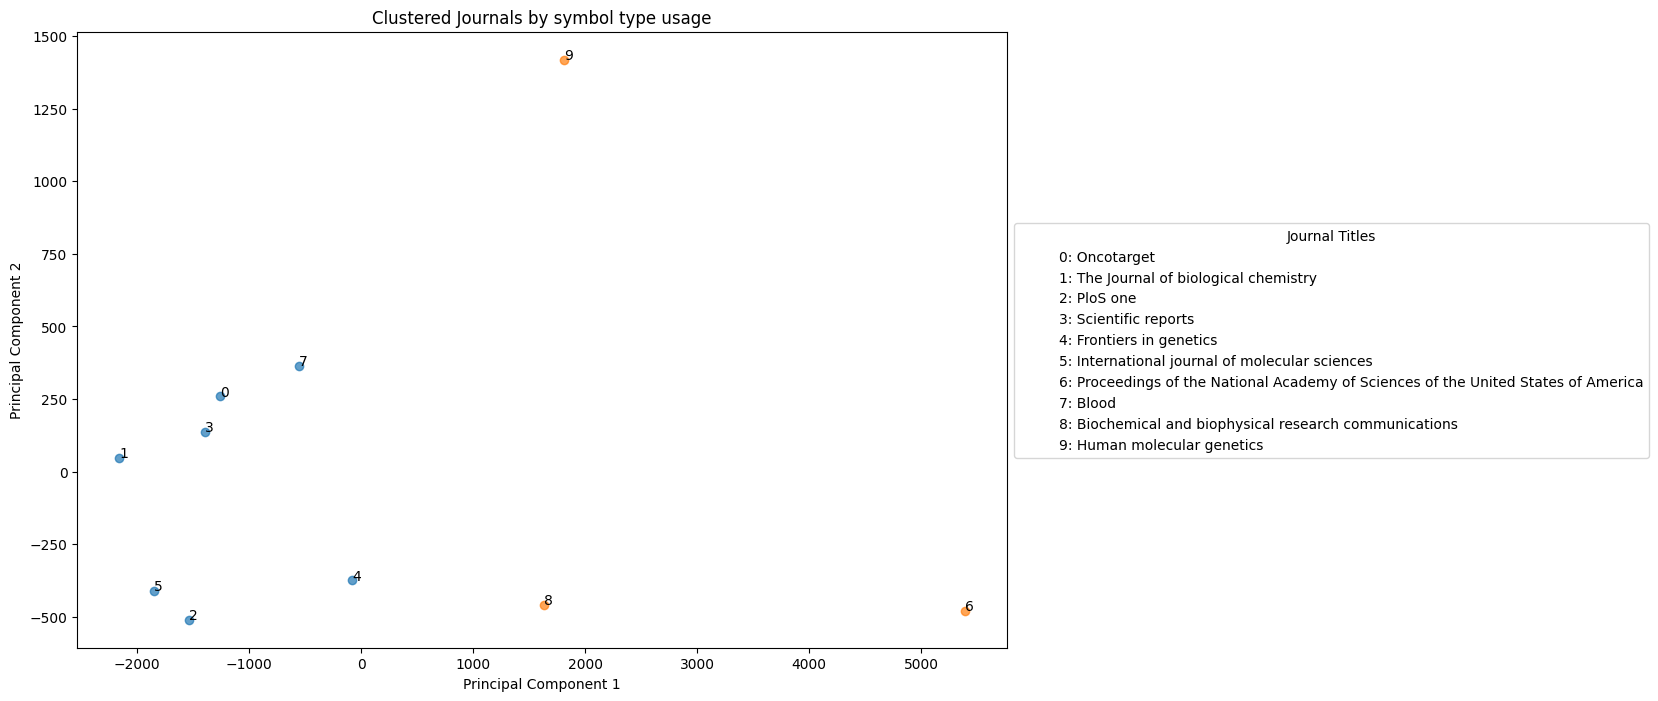

In [19]:
cluster_journal_symbol(subset_adoption_df, 2)

/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


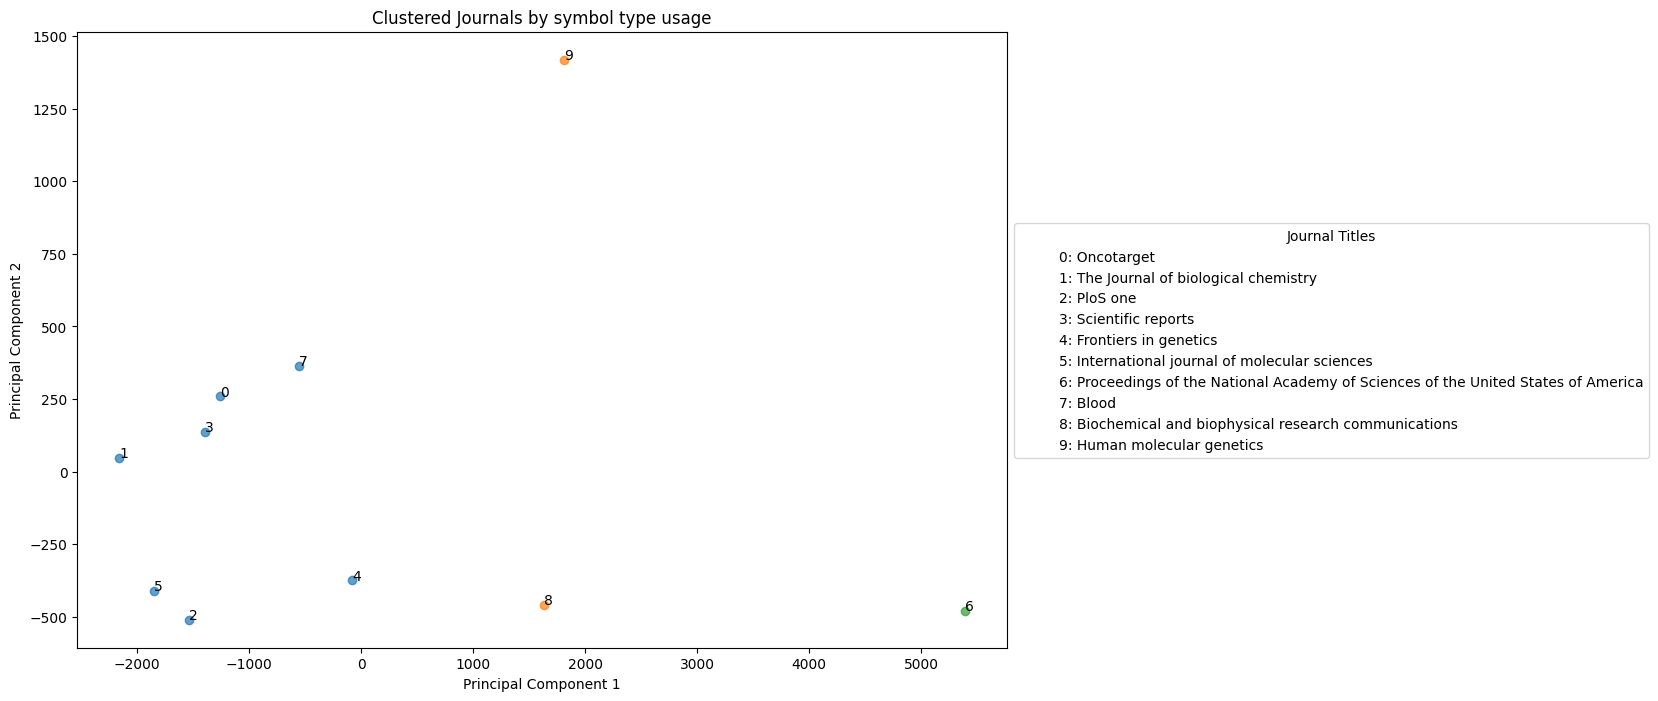

In [20]:
cluster_journal_symbol(subset_adoption_df, 3)

/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/javier/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


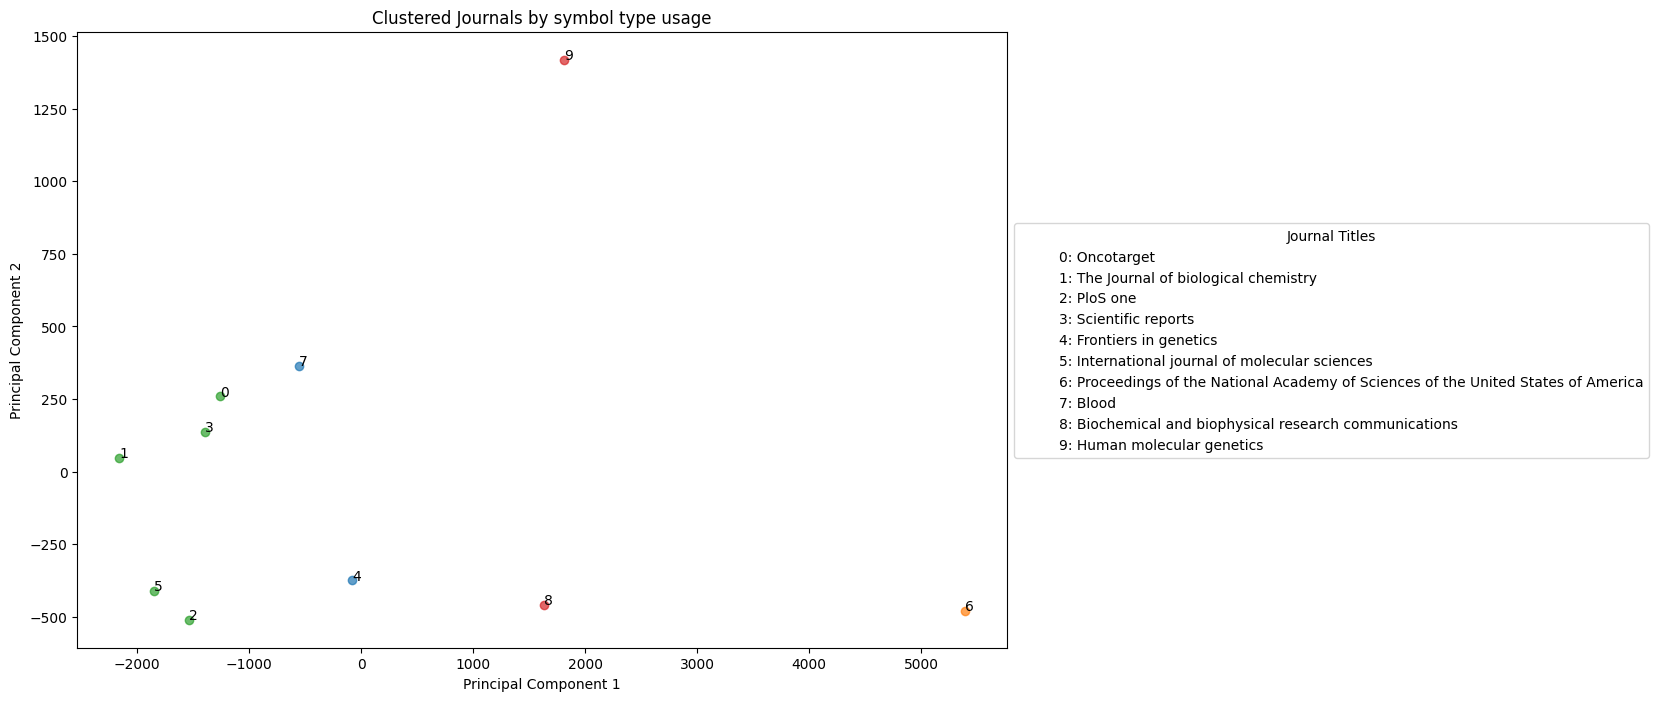

In [21]:
cluster_journal_symbol(subset_adoption_df, 4)